Total images: 52712
Using device: cpu


Extracting embeddings: 100%|█████████████████████████████████████████████████████| 14218/14218 [58:34<00:00,  4.05it/s]


Gallery: (12612, 2048) Query: (14218, 2048)
FAISS index size: 12612
Top-5 similar results for Query #0:


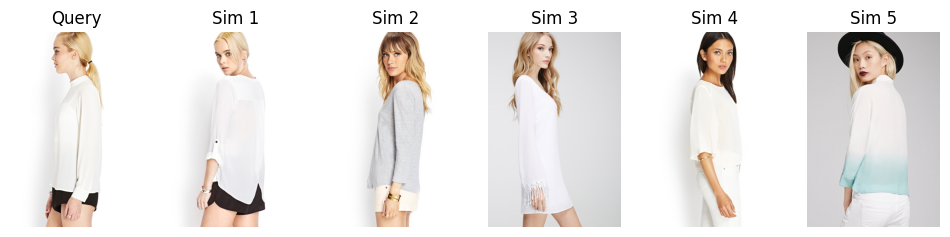

✅ Saved FAISS index to: C:\Users\dilku\deepfashion-recsys\data\deepfashion\faiss_gallery.index


In [1]:
# 2. BASELINE EMBEDDINGS + FAISS


# Importing the libraries
import torch
import torchvision as tv
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import faiss
import matplotlib.pyplot as plt



# 1. Setup & Load Dataset Index

root = Path(r"C:\Users\dilku\deepfashion-recsys\data\deepfashion")
index_path = root.parent / "deepfashion_index.csv"

df = pd.read_csv(index_path)
print("Total images:", len(df))
df.head()



# 2. Building Image Transform

img_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])



# 3. Load Pretrained Backbone (ResNet50 baseline)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

backbone = tv.models.resnet50(weights=tv.models.ResNet50_Weights.DEFAULT)
backbone.fc = torch.nn.Identity()   # remove final classifier
backbone = backbone.to(device).eval()



# 4. Embedding Extraction Function

@torch.no_grad()
def extract_embeddings(image_paths):
    embs = []
    for path in tqdm(image_paths, desc="Extracting embeddings"):
        try:
            img = Image.open(path).convert("RGB")
            x = img_tfms(img).unsqueeze(0).to(device)
            feat = backbone(x).cpu().numpy()
            embs.append(feat)
        except Exception as e:
            print(f"⚠️ Skipped {path}: {e}")
    return np.concatenate(embs, axis=0)



# 5. Extract Gallery & Query Embeddings

gallery_df = df[df["split"].str.contains("gallery")]
query_df   = df[df["split"].str.contains("query")]

gallery_embs = extract_embeddings(gallery_df["image_path"].tolist())
query_embs   = extract_embeddings(query_df["image_path"].tolist())

# Save for reuse
np.save(root / "gallery_embs.npy", gallery_embs)
np.save(root / "query_embs.npy", query_embs)

print("Gallery:", gallery_embs.shape, "Query:", query_embs.shape)



# 6. Building FAISS Index

def build_faiss_index(vecs, metric="cosine"):
    xb = vecs.astype("float32")
    if metric == "cosine":
        faiss.normalize_L2(xb)
        index = faiss.IndexFlatIP(xb.shape[1])
    else:
        index = faiss.IndexFlatL2(xb.shape[1])
    index.add(xb)
    return index

index = build_faiss_index(gallery_embs, metric="cosine")
print("FAISS index size:", index.ntotal)



# 7. A Quick Retrieval Demo
def retrieve_similar(idx=0, topk=5):
    xq = query_embs[idx:idx+1].astype("float32")
    faiss.normalize_L2(xq)
    D, I = index.search(xq, topk)
    print(f"Top-{topk} similar results for Query #{idx}:")
    
    plt.figure(figsize=(12, 3))
    qimg = Image.open(query_df.iloc[idx]["image_path"]).convert("RGB")
    plt.subplot(1, topk + 1, 1)
    plt.imshow(qimg)
    plt.axis("off")
    plt.title("Query")

    for i, gi in enumerate(I[0]):
        sim_img = Image.open(gallery_df.iloc[gi]["image_path"]).convert("RGB")
        plt.subplot(1, topk + 1, i + 2)
        plt.imshow(sim_img)
        plt.axis("off")
        plt.title(f"Sim {i+1}")
    plt.show()

retrieve_similar(idx=0, topk=5)



# 8. Save FAISS Index

faiss.write_index(index, str(root / "faiss_gallery.index"))
print("✅ Saved FAISS index to:", root / "faiss_gallery.index")
